In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from bbl_utils import *
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

### Physical parameters

In [4]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

In [5]:
dx = 500.
delta_t = 60.
diter = 28800

iter0 = 3182400
Niter = 22
dt = 1728000

iters = np.arange(iter0, iter0 + diter*Niter, diter)

### Test grid pre-processing

In [8]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_rest-tracer/run/"
ds = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag", "tracer01Diag", "tracer02Diag"], delta_t=60.)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [9]:
extend_multiples = [-1, 0]
xslice = [-1e5, 3e5]

Lx = ds['XC'].size*dx
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds = ds.sel(XC=slice(*xslice), XG=slice(*xslice))
H = ds['Depth'].max().values.copy().astype('>f8')
ds, grid = preprocess(ds, θ)
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

In [10]:
TRAC01_xy = (ds['TRAC01']*ds['drF']).sum(dim='Z').isel(time=-1).compute()
TRAC01_xy /= TRAC01_xy.max()
TRAC01_xz = (ds['TRAC01']*ds['rA']).sum(dim='YC').isel(time=-1).compute()
TRAC01_xz /= TRAC01_xz.max()

TRAC02_xy = (ds['TRAC02']*ds['drF']).sum(dim='Z').isel(time=-1).compute()
TRAC02_xy /= TRAC02_xy.max()
TRAC02_xz = (ds['TRAC02']*ds['rA']).sum(dim='YC').isel(time=-1).compute()
TRAC02_xz /= TRAC02_xz.max()

## Temperature and tracer budgets

In [13]:
TH = tracer_flux_budget('_TH')
TH['total_tendency_TH'] = TH['conv_total_flux_TH'].fillna(0.)
TH['total_tendency_TH_truth'] = ds.TOTTTEND * volume * day2seconds
TH['diff_tendency_TH'] = TH['conv_horiz_diff_flux_TH'] + TH['conv_vert_diff_flux_TH'] + TH['conv_vert_diff_flux_anom_TH']
TH['adv_tendency_TH'] = TH['conv_horiz_adv_flux_TH'] + TH['conv_vert_adv_flux_TH'] + TH['conv_adv_flux_anom_TH']

Tr01 = tracer_flux_budget('Tr01')
Tr01['total_tendency_Tr01'] = Tr01['conv_total_fluxTr01'].fillna(0.)
Tr01['total_tendency_Tr01_truth'] = ds.Tp_gTr01 * volume
Tr01['diff_tendency_Tr01'] = Tr01['conv_horiz_diff_fluxTr01'] + Tr01['conv_vert_diff_fluxTr01']
Tr01['adv_tendency_Tr01'] = Tr01['conv_horiz_adv_fluxTr01'] + Tr01['conv_vert_adv_fluxTr01']

Tr02 = tracer_flux_budget('Tr02')
Tr02['total_tendency_Tr02'] = Tr02['conv_total_fluxTr02'].fillna(0.)
Tr02['total_tendency_Tr02_truth'] = ds.Tp_gTr02 * volume
Tr02['diff_tendency_Tr02'] = Tr02['conv_horiz_diff_fluxTr02'] + Tr02['conv_vert_diff_fluxTr02']
Tr02['adv_tendency_Tr02'] = Tr02['conv_horiz_adv_fluxTr02'] + Tr02['conv_vert_adv_fluxTr02']

### Watermass transformations

\begin{equation}
T(\Theta) = \partial_{\Theta} \int_{V_{b'<b}} \nabla \cdot \left( \kappa \nabla \Theta \right) \;\text{d}V
\end{equation}

In [14]:
dθ = 0.1
θ_levs = np.arange(1.5, 2.5+dθ, dθ)
formation = np.zeros((θ_levs.size, 3))
for k, θ_lev in enumerate(θ_levs):
    print(k, end=", ")
    formation[k, 0] = TH['diff_tendency_TH'].where((ds['θ'] < θ_lev)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values
    formation[k, 1] = TH['diff_tendency_TH'].where((ds['θ'] < θ_lev) | (TH['diff_tendency_TH'] >= 0.)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values
    formation[k, 2] = TH['diff_tendency_TH'].where((ds['θ'] < θ_lev) | (TH['diff_tendency_TH'] <= 0.)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values
    
transformation = -np.diff(formation, axis=0)/dθ

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

In [35]:
formation_dbdt = np.zeros(θ_levs.size)
for k, θ_lev in enumerate(θ_levs):
    print(k, end=", ")
    formation_dbdt[k] = TH['total_tendency_TH_truth'].where((ds['θ'] < θ_lev)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values

transformation_dbdt = -np.diff(formation_dbdt)/dθ

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

(1.55, 2.35)

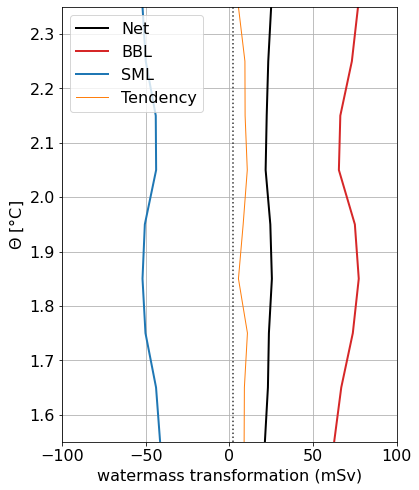

In [56]:
θ_levs_f = 0.5*(θ_levs[1:] + θ_levs[0:-1])
labels = ['Net', 'BBL', 'SML']
colors = ['k', 'C3', 'C0']

plt.figure(figsize=(6,8))
for i in range(3):
    plt.plot(transformation[:,i]*1.e-3, θ_levs_f, label=labels[i], color=colors[i], lw=2.)

plt.plot(transformation_dbdt[:]*1.e-3, θ_levs_f, color="C1", lw=1., label="Tendency")
    
Tinf = 5.2e-5 * np.tan(θ)**(-1) * 120 * 500
plt.axvline(x=Tinf*1.e-3, alpha=0.8, linestyle=":", color="k")
plt.grid(True)
plt.legend()
plt.xlabel("watermass transformation (mSv)")
plt.ylabel(r"$\Theta$ [$\degree$C]")
plt.xlim([-100, 100])
plt.ylim([1.55, 2.35])

(0.0, 400000.0)

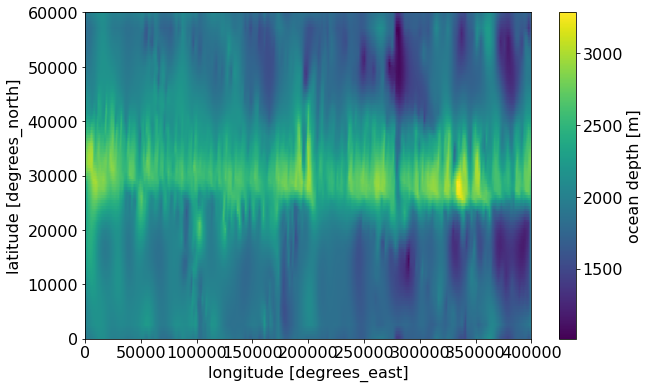

In [72]:
ds['Depth'].plot()
plt.xlim([0*1.e4,4e5])

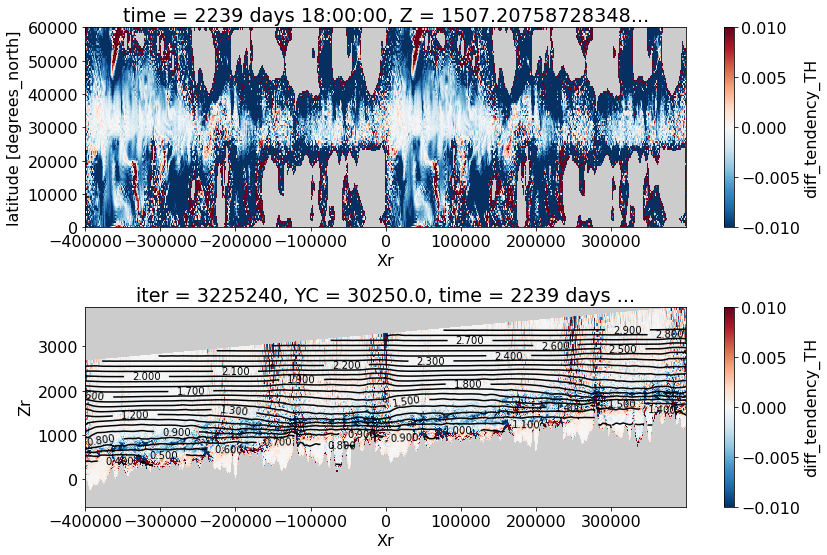

In [45]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
q = TH['diff_tendency_TH'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=1500, method='nearest').plot(x='Xr', y='YC')
q.set_clim([-1.e-2,1.e-2])

ax = plt.subplot(2,1,2, facecolor=nancol)
q = TH['diff_tendency_TH'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr')
q.set_clim([-1.e-2,1.e-2])
CS = ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(0., 3., 0.1), colors='k', lw=0.75)
ax.clabel(CS, inline=1, fontsize=10)
plt.tight_layout()
#plt.ylim([100, 1700])

(1200.0, 3000.0)

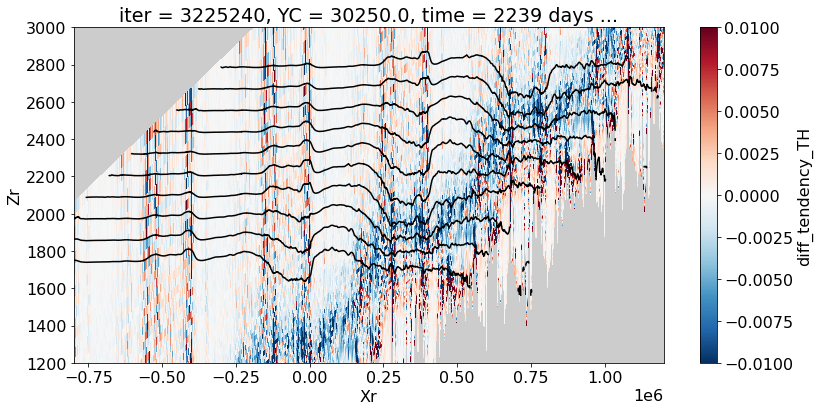

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(1,1,1, facecolor=nancol)
q = TH['diff_tendency_TH'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr')
q.set_clim([-1.e-2,1.e-2])
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(1.5, 2.5, 0.1), colors='k', lw=0.75)
plt.tight_layout()
plt.ylim([1200, 3000])

### Verification: closing the temperature and tracer budgets

In [ ]:
TH_chk = TH[['total_tendency_TH', 'total_tendency_TH_truth']].sum(dim=['Z', 'YC']).mean(dim='time').load()

Tr01_chk = Tr01[['total_tendency_Tr01', 'total_tendency_Tr01_truth']].sum(dim=['Z', 'YC']).mean(dim='time').load()

Tr02_chk = Tr02[['total_tendency_Tr02', 'total_tendency_Tr02_truth']].sum(dim=['Z', 'YC']).mean(dim='time').load()

[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.1s
[########################################] | 100

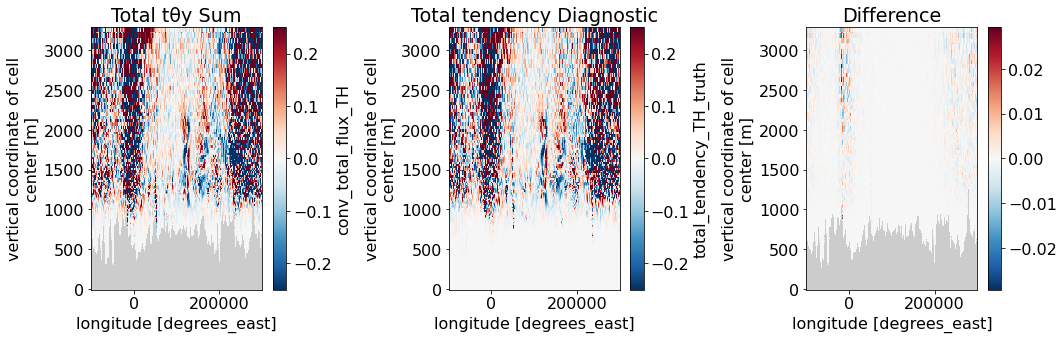

In [320]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
q = TH['conv_total_flux_TH'].isel(YC=60, time=-1).plot()
q.set_clim([-0.25, 0.25])
plt.title("Total tθy Sum")

plt.subplot(1,3,2)
q = TH['total_tendency_TH_truth'].isel(YC=60, time=-1).plot()
q.set_clim([-0.25,0.25])
plt.title("Total tendency Diagnostic")

plt.subplot(1,3,3)
(TH['total_tendency_TH_truth'].isel(YC=60, time=-1) - TH['conv_total_flux_TH'].isel(YC=60, time=-1)).plot()
plt.title("Difference")

plt.tight_layout()

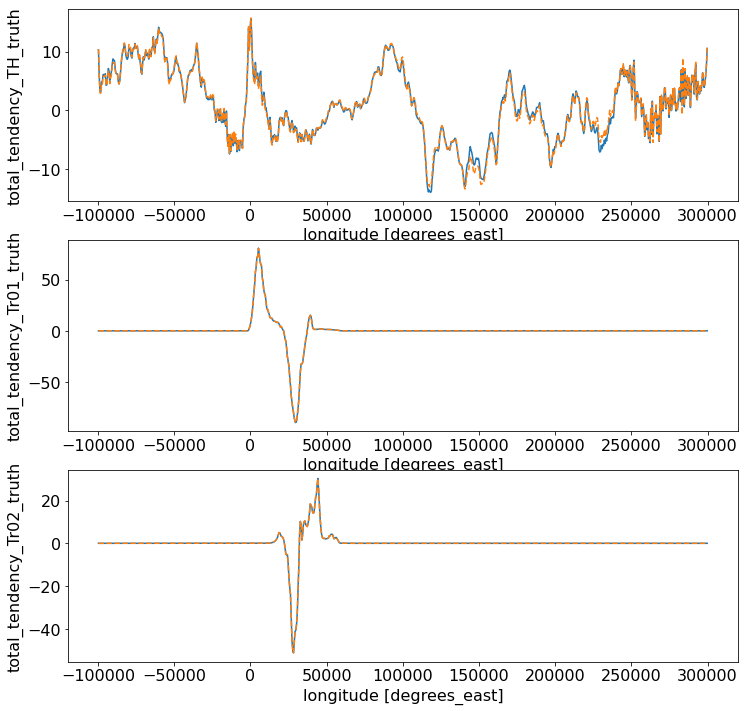

In [321]:
plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
TH_chk['total_tendency_TH'].plot()
TH_chk['total_tendency_TH_truth'].plot(linestyle="--")

plt.subplot(3,1,2)
Tr01_chk['total_tendency_Tr01'].plot()
Tr01_chk['total_tendency_Tr01_truth'].plot(linestyle="--")

plt.subplot(3,1,3)
Tr02_chk['total_tendency_Tr02'].plot()
Tr02_chk['total_tendency_Tr02_truth'].plot(linestyle="--")

### Tracer-weighted density (first moment)

The rate of change of the first temperature moment $\overline{\Theta} = \dfrac{\int \Theta c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we use the follow , where each term can be diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed. In practice, hyperdiffusion has a small but non-zero effect on the buoyancy budget and since it is omitted here, it introduces small errors in the budget.

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [322]:
ds['θ_dcdt'] = ds['θ'] * ds['Tp_gTr01'] * volume
ds['c_dθdt'] = ds['TRAC01'] * (ds['TOTTTEND']* day2seconds) * volume

ds['d(cθ)dt'] = ds['θ_dcdt'] + ds['c_dθdt']

In [ ]:
ds['M_TRAC01'] = (ds['TRAC01']*volume).sum(dim=['Z', 'YC', 'XC']).compute()
ds['θbar'] = (ds['d(cθ)dt'].sum(dim=['Z', 'YC', 'XC']) / ds['M_TRAC01']).compute()

In [ ]:
ds['c_div_uθ'] = ds['TRAC01']*TH['adv_tendency_TH']
ds['θ_div_uc'] = ds['θ']*Tr01['adv_tendency_Tr01']

In [ ]:
ds['c_div_Fθ'] = ds['TRAC01']*TH['diff_tendency_TH']
ds['θ_div_Fc'] = ds['θ']*Tr01['diff_tendency_Tr01']

In [ ]:
ds['d(cθ)dt_DIFF'] = ds['c_div_Fθ'] + ds['θ_div_Fc']
ds['θbar_DIFF'] = (ds['d(cθ)dt_DIFF'].sum(dim=['Z', 'YC', 'XC']) / ds['M_TRAC01']).compute()

ds['d(cθ)dt_ADV'] = ds['c_div_uθ'] + ds['θ_div_uc']
ds['θbar_ADV'] = (ds['d(cθ)dt_ADV'].sum(dim=['Z', 'YC', 'XC']) / ds['M_TRAC01']).compute()

ds['θbar_RHS'] = ds['θbar_DIFF'] + ds['θbar_ADV']

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100

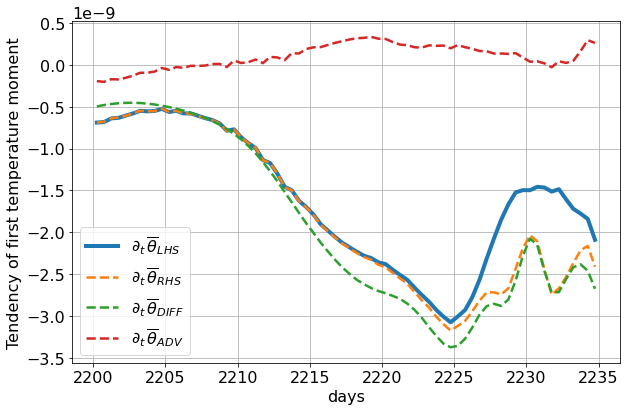

In [343]:
ds['days'] = ds['time'].astype("float64")*(1.e-9)/86400.
ds = ds.assign_coords({'days': ds['days']})

plt.figure(figsize=(9,6))
ds['θbar'].plot(x='days', lw=4, label=r"$\partial_{t}\, \overline{\theta}_{LHS}$")
ds['θbar_RHS'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{RHS}$")
ds['θbar_DIFF'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{DIFF}$")
ds['θbar_ADV'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{ADV}$")
plt.legend()
plt.ylabel("Tendency of first temperature moment")
plt.grid(True)

plt.tight_layout()

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100

(300.0, 2000.0)

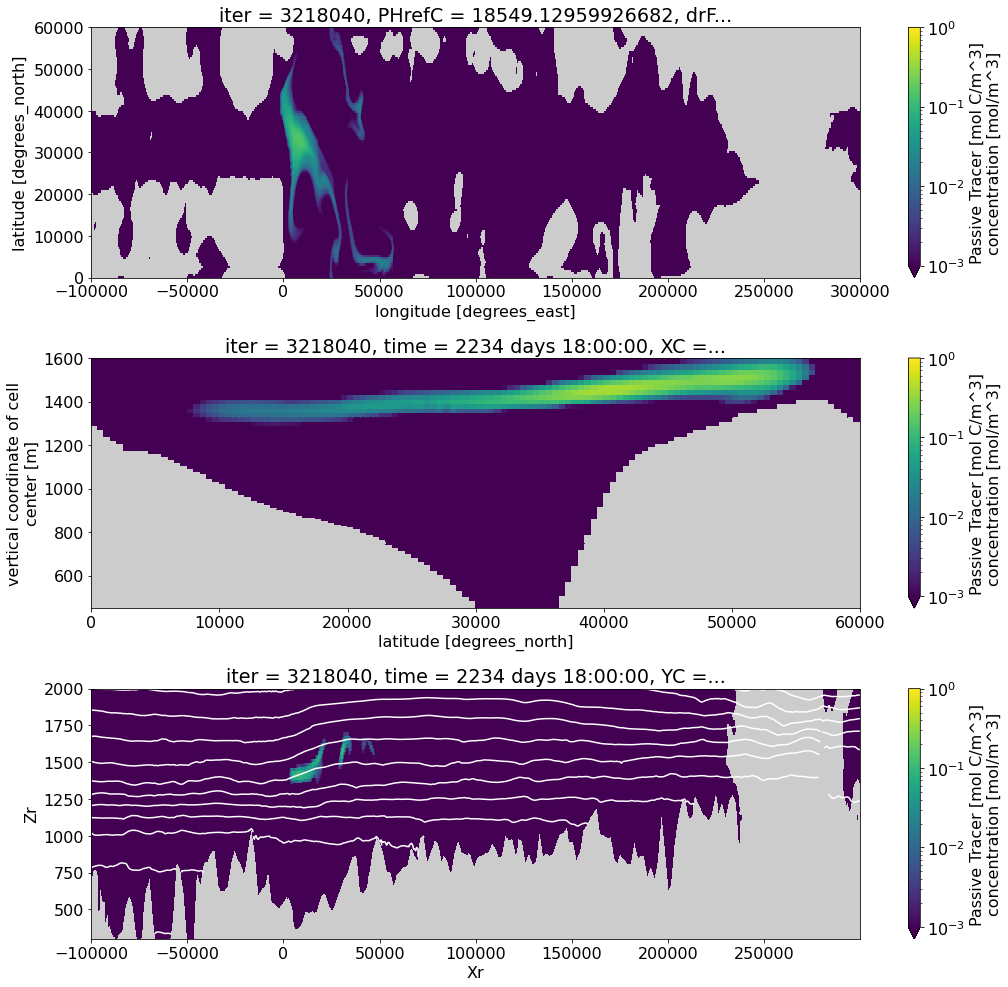

In [375]:
import matplotlib

plt.figure(figsize=(15,14))
plt.subplot(3,1,1, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=1390, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))

plt.subplot(3,1,2, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).sel(XC=5.e3, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
plt.tight_layout()
plt.ylim([450, 1600])

plt.subplot(3,1,3, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(0., 3., 0.1), colors='w', lw=0.75)

plt.tight_layout()
plt.ylim([300, 2000])

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100

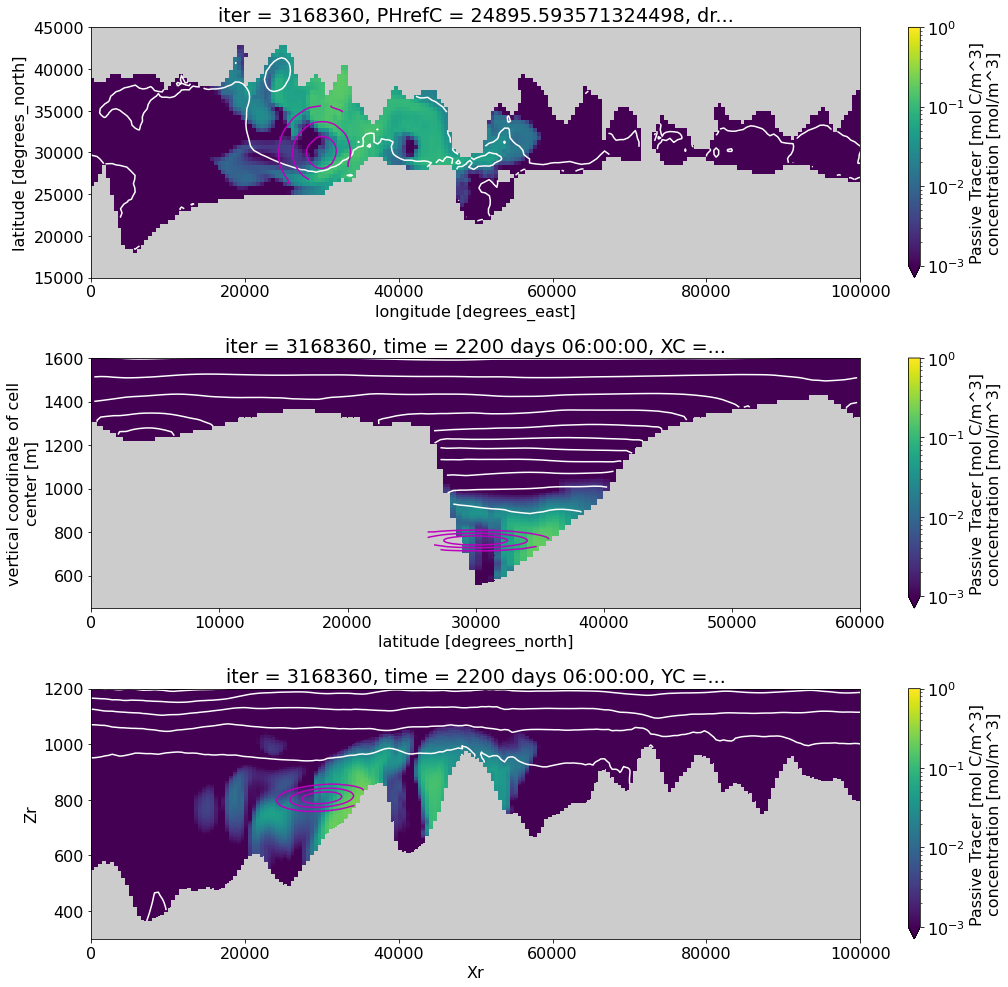

In [394]:
import matplotlib

plt.figure(figsize=(15,14))
plt.subplot(3,1,1, facecolor=nancol)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=850, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=850, method='nearest').plot.contour(levels=np.arange(-1., 1.5, 0.01), colors='w', lw=0.75)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=0).sel(Z=750, method='nearest').plot.contour(levels=np.arange(0.25, 1., 0.25), colors='m', lw=0.75)
plt.xlim([0,1.0e5])
plt.ylim([1.5e4,4.5e4])

plt.subplot(3,1,2, facecolor=nancol)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=-1).sel(XC=4.e4, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).sel(XC=4.e4, method='nearest').plot.contour(levels=np.arange(-1., 1.5, 0.05), colors='w', lw=0.75)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=0).sel(XC=3.e4, method='nearest').plot.contour(levels=np.arange(0.25, 1., 0.25), colors='m', lw=0.75)
plt.tight_layout()
plt.ylim([450, 1600])

plt.subplot(3,1,3, facecolor=nancol)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(-1., 1.5, 0.05), colors='w', lw=0.75)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=0, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(0.25, 1., 0.25), colors='m', lw=0.75)
plt.ylim([300, 1200])
plt.xlim([0,1.0e5])

plt.tight_layout()


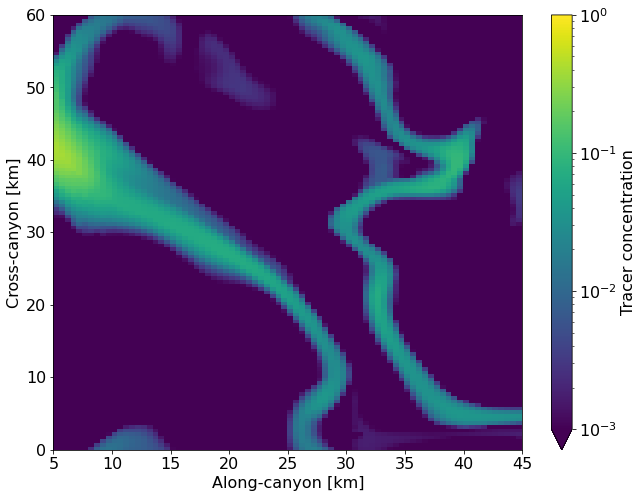

In [126]:
plt.figure(figsize=(10.5,8))
for i, t in enumerate(ds['time'].values):
    plt.clf()
    q = qplot.sel(time=t).plot(x='Xkm', y='Ykm',norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
    plt.xlim([5, 45])
    plt.ylim([0, 60])
    plt.xlabel("Along-canyon [km]")
    plt.ylabel("Cross-canyon [km]")
    plt.title("")
    q.colorbar.set_label("Tracer concentration")
    plt.savefig(f"../../figures/movies/BBTRE_release/{str(i).zfill(3)}.png", dpi=100., bbox_inches="tight")